In [1]:
import numpy as np
import pandas as pd 
import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

# Get The Data

In [2]:
# load data
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")

In [3]:
# check datatype
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [4]:
# check null
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# Prepare The Data

In [5]:
#remove rows where customerID are NA
df = df.dropna()

In [6]:
# check info after dropping
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [7]:
df["TransactionDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TransactionDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [9]:
#remove canceled orders
df = df[df['Quantity']>0]

In [10]:
#exploring the unique values
print("Number of transactions: ", df['InvoiceNo'].nunique())
print("Number of products bought: ", df['StockCode'].nunique())
print("Number of customers:", df['CustomerID'].nunique() )

Number of transactions:  18536
Number of products bought:  3665
Number of customers: 4339


#  RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses analyzing past purchase behavior to divide customers into groups. This model is used based on three variables, R : days since last purchase, F : total number of purchases, and M : total money spent for each customer.

## Recency

In [11]:
# last purchase
now = pd.to_datetime(df['TransactionDate'].max())
print(now)

2011-12-09 00:00:00


In [12]:
#group by customers and check last date of purchase
recency_df = df.groupby(by = 'CustomerID', as_index=False)['TransactionDate'].max()
recency_df.columns = ['CustomerID', 'LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [13]:
# calculate recency
recency_df['LastPurchaseDate'] = pd.to_datetime(recency_df['LastPurchaseDate'], format = '%Y/%m/%d')
recency_df['Recency'] = (now - recency_df['LastPurchaseDate']).dt.days
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


## Frequency

In [14]:
# calculate frequency of unique purchase
df_copy = df
df_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = df_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


## Monetary

In [15]:
# create TotalCost for Monetary
df["TotalCost"] = df["Quantity"]*df["UnitPrice"]

In [16]:
#calculate monetary
monetary_df = df_copy.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,163.16
2,12348.0,331.36
3,12349.0,15.00
4,12350.0,25.20


## RFM

In [17]:
#merge data frame
rf = pd.merge(recency_df, frequency_df, on="CustomerID")
rfm = pd.merge(rf, monetary_df, on='CustomerID')
rfm.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary
0,12346.0,2011-01-18,325,1,77183.60
1,12347.0,2011-12-07,2,7,163.16
2,12348.0,2011-09-25,75,4,331.36
3,12349.0,2011-11-21,18,1,15.00
4,12350.0,2011-02-02,310,1,25.20


In [18]:
#rfm quartiles
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles

,CustomerID,Recency,Frequency,Monetary
0.25,13812.5,17.0,1.0,17.700
0.50,15299.0,50.0,2.0,47.000
0.75,16778.5,141.5,5.0,130.045


In [19]:
quantiles.to_dict()

{'CustomerID': {0.25: 13812.5, 0.5: 15299.0, 0.75: 16778.5},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.5},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.700000000000003, 0.5: 47.0, 0.75: 130.04500000000002}}

In [20]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [21]:
#create rfm segmentation table
rfm_segmentation = rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles))

In [22]:
# calculate rfm score
rfm_segmentation['RFMScore'] =  rfm_segmentation["R_Quartile"].map(str) + rfm_segmentation["F_Quartile"].map(str) + rfm_segmentation["M_Quartile"].map(str)
rfm_segmentation.head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346.0,2011-01-18,325,1,77183.60,1,1,4,114
1,12347.0,2011-12-07,2,7,163.16,4,4,4,444
2,12348.0,2011-09-25,75,4,331.36,2,3,4,234
3,12349.0,2011-11-21,18,1,15.00,3,1,1,311
4,12350.0,2011-02-02,310,1,25.20,1,1,2,112


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most money.

In [28]:
# set segmentation name
segmentation=[]
for i,j,k in zip(rfm["RFMScore"], rfm["F_Quartile"], rfm["M_Quartile"]):
    if i == "444":
        segmentation.append("Best Customers")
    elif i == "244":
        segmentation.append("Almost Lost Customers")
    elif i == "144":
        segmentation.append("Lost Customers")
    elif j == 4:
        segmentation.append("Loyal Customers")
    elif k == 4:
        segmentation.append("Big Spenders Customers")
    else:
        segmentation.append("Other")

In [29]:
rfm["Segmentation"] = segmentation
rfm['Segmentation'].value_counts()

Other                     3026
Big Spenders Customers     441
Best Customers             401
Loyal Customers            394
Almost Lost Customers       66
Lost Customers              11
Name: Segmentation, dtype: int64

### the best customer

In [30]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head()

,CustomerID,LastPurchaseDate,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segmentation
4202,18102.0,2011-12-09,0,60,42053.60,4,4,4,444,Best Customers
4094,17949.0,2011-12-08,1,45,29999.69,4,4,4,444,Best Customers
3729,17450.0,2011-12-01,8,46,26768.97,4,4,4,444,Best Customers
1690,14646.0,2011-12-08,1,74,19045.06,4,4,4,444,Best Customers
2689,16013.0,2011-12-06,3,47,17895.28,4,4,4,444,Best Customers


In [31]:
segmen = rfm_segmentation.groupby("Segmentation", as_index=False)["CustomerID"].nunique().sort_values(by = "CustomerID", ascending=False).reset_index()

segmen["Segmentation (%)"] = round(segmen["CustomerID"]/sum(segmen["CustomerID"]) *100, 1)

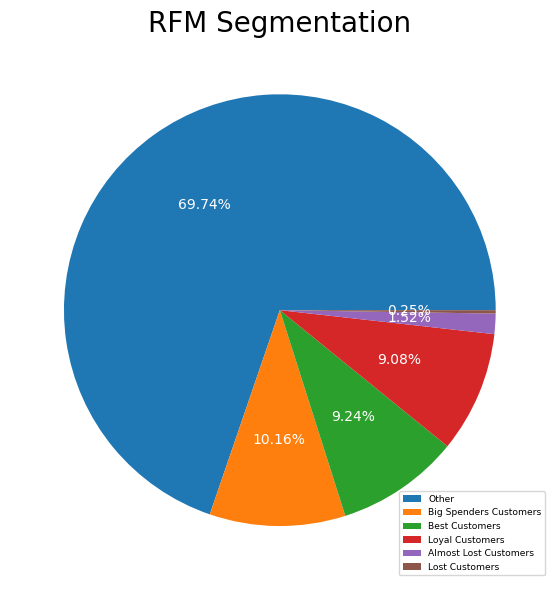

In [32]:
# visualization
plt.figure(figsize=(6,6))
plt.pie(segmen["CustomerID"], 
        autopct = '%1.2f%%', 
        textprops = {'fontsize' : 10, 
                     'color' : 'white'})
plt.title("RFM Segmentation", fontsize=20)
plt.legend(segmen["Segmentation"], loc='lower right', prop={'size': 6.6})
plt.tight_layout()
plt.show()

Strategies to gain more profit are :
1. create a discount voucher for each customer segmentation to increase salles and also keeping the customers on making transactions.
2. create a loyalty program to increase customer shopping frequency especially for the "Almost Lost" Customer. 